# Echo state networks

[![Download JupyterNotebook](https://img.shields.io/badge/Download-Notebook-orange?style=for-the-badge&logo=Jupyter)](https://raw.githubusercontent.com/ANNarchy/ANNarchy.github.io/master/notebooks/RC.ipynb) [![Download JupyterNotebook](https://img.shields.io/badge/Open_in-Colab-blue?style=for-the-badge&logo=Jupyter)](https://colab.research.google.com/github/ANNarchy/ANNarchy.github.io/blob/master/notebooks/RC.ipynb)

If you run this notebook in colab, first uncomment and run this cell to install ANNarchy:

In [1]:
#!pip install ANNarchy

This notebook demonstrates how to implement a simple Echo state network (ESN) with ANNarchy. It is a simple rate-coded network, with a population of recurrently-connected neurons and a readout layer which will be learned offline using `scikit-learn`. The task will be a simple univariate regression.

![](../tutorial/img/rc.jpg)

Let's start by importing ANNarchy. 

The `clear()` command is necessary in notebooks when recreating a network. If you re-run the cells creating a network without calling `clear()` first, populations will add up, and the results may not be what you expect.

`setup()` sets various parameters, such as the step size `dt` in milliseconds. By default, `dt` is 1.0, so the call is not necessary here.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import ANNarchy as ann

ann.clear()
ann.setup(dt=1.0)

ANNarchy 4.8 (4.8.3) on darwin (posix).


Each neuron in the reservoir follows the following equations:

$$
    \tau \frac{dx(t)}{dt} + x(t) = \sum_\text{input} W^\text{IN} \, r^\text{IN}(t) + g \,  \sum_\text{rec} W^\text{REC} \, r(t) + \xi(t)
$$

$$
    r(t) = \tanh(x(t))
$$

where $\xi(t)$ is a uniform noise.

The neuron has three parameters and two variables:

In [3]:
ESN_Neuron = ann.Neuron(
    parameters = dict(
        tau = 30.0,
        g = 1.0,
        noise = 0.01,
    ),
    equations = [
        'tau * dx/dt + x = sum(in) + g * sum(exc) + noise * Uniform(-1, 1)',
        'r = tanh(x)',
    ]
)

The echo-state network will be a population of 400 neuron.

In [4]:
N = 400
pop = ann.Population(N, ESN_Neuron)

We can specify the value of the parameters from Python, this will override the value defined in the neuron description. We can give single float values or numpy arrays of the correct shape:

In [5]:
pop.tau = 30.0
pop.g = 1.4
pop.noise = 0.01

The input to the reservoir is a single value, we create a special population `InputArray` that does nothing except storing a variable called `r` that can be set externally.

In [6]:
inp = ann.InputArray(1)
inp.r = 0.0

Input weights are uniformly distributed between -1 and 1.

In [7]:
Wi = ann.Projection(inp, pop, 'in')
Wi.connect_all_to_all(weights=ann.Uniform(-1.0, 1.0))


Recurrent weights are sampled from the normal distribution with mean 0 and variance $g^2 / N$. Here, we put the synaptic scaling $g$ inside the neuron.

In [8]:
Wrec = ann.Projection(pop, pop, 'exc')
Wrec.connect_all_to_all(weights=ann.Normal(0., 1/np.sqrt(N)))

In [9]:
ann.compile()

Compiling ...  OK 


We create a monitor to record the evolution of the firing rates in the reservoir during the simulation.

In [10]:
m = ann.Monitor(pop, 'r')
n = ann.Monitor(inp, 'r')

A single trial lasts 3 second by default, with a step input between 100 and 200 ms. We define the trial in a method, so we can run it multiple times.

In [11]:
def trial(T=3000.):
    "Runs two trials for a given spectral radius."

    # Reset firing rates
    inp.r = 0.0
    pop.x = 0.0
    pop.r = 0.0
    
    # Run the trial
    ann.simulate(100.)
    inp.r = 1.0
    ann.simulate(100.0) # initial stimulation
    inp.r = 0.0
    ann.simulate(T - 200.)
    
    return m.get('r')

We run two trials successively to look at the chaoticity depending on $g$. 

In [12]:
pop.g = 1.5
data1 = trial()
data2 = trial()

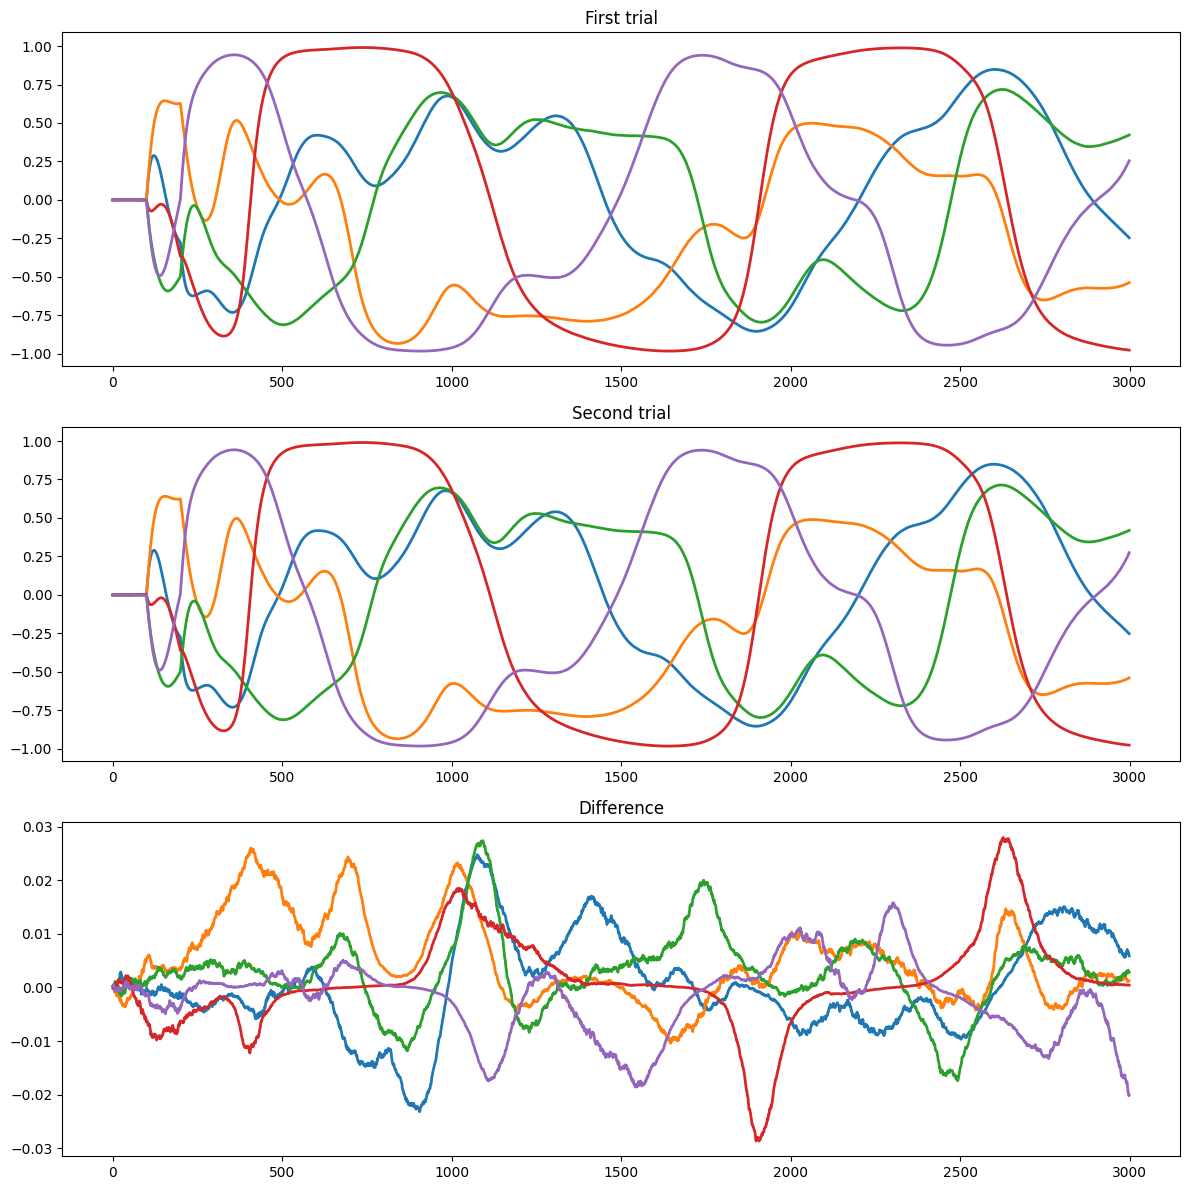

In [13]:
plt.figure(figsize=(12, 12))
plt.subplot(311)
plt.title("First trial")
for i in range(5):
    plt.plot(data1[:, i], lw=2)
plt.subplot(312)
plt.title("Second trial")
for i in range(5):
    plt.plot(data2[:, i], lw=2)
plt.subplot(313)
plt.title("Difference")
for i in range(5):
    plt.plot(data1[:, i] - data2[:, i], lw=2)

plt.tight_layout()
plt.show()

We can now train the readout neurons to reproduce a step signal after 2 seconds.

For simplicity, we just train a L1-regularized linear regression (LASSO) on the reservoir activity using `scikit-learn`.

In [14]:
target = np.zeros(3000)
target[2000:2500] = 1.0

In [15]:
from sklearn import linear_model

reg = linear_model.Lasso(alpha=0.001, max_iter=10000)
reg.fit(data1, target)
pred = reg.predict(data2)

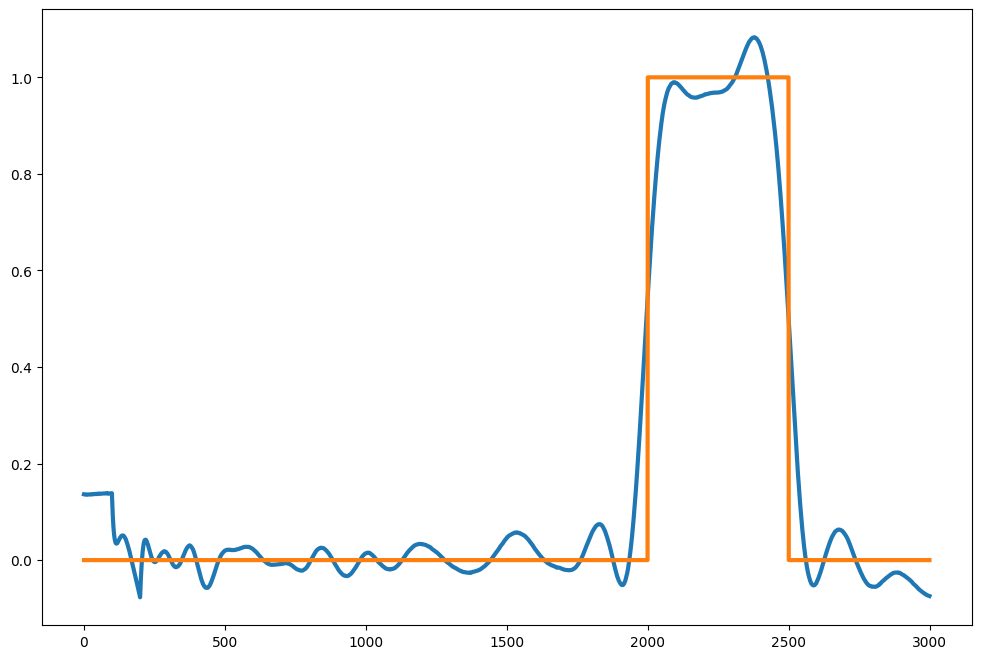

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(pred, lw=3)
plt.plot(target, lw=3)
plt.show()